## Imports

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
import copy

## Load MNIST

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

In [3]:
dataset = MNIST(root='MNIST', download=True, transform=transform)

## Diffusion Class

In [4]:
class DDPM:
    def __init__(self, T=1000, beta_start=1e-4, beta_end=2e-2, img_size=32, device='cuda'):
        self.T = T
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.generate_noise_schedule()
        self.alpha = 1 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def generate_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.T, device=self.device)

    def forward_diffusion(self, images, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        noise = torch.randn_like(images)
        return sqrt_alpha_hat * images + sqrt_one_minus_alpha_hat * noise, noise
    
    def sample_timesteps(self, batch_size):
        return torch.randint(low=1, high=self.T, size=(batch_size,), device=self.device)
    
    def sample(self, model, batch_size, y=None, process=False):
        model.eval()
        xs = []
        with torch.no_grad():
            x = torch.randn((batch_size, 1, self.img_size, self.img_size), device=self.device)
            for i in reversed(range(1, self.T)):
                if process:
                    xs.append(x)
                t = torch.tensor(i).expand((batch_size,)).to(self.device)
                noise_pred = model(x, t, y)
                alpha_t = (self.alpha[t])[:, None, None, None]
                alpha_hat_t = (self.alpha_hat[t])[:, None, None, None]
                sigma_t = torch.sqrt(self.beta[t])[:, None, None, None]
                noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)
                x = (1 / torch.sqrt(alpha_t)) * (x - (((1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)) * noise_pred)) + sigma_t * noise
        
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2.0
        x = (x * 255).to(torch.uint8)

        if process:
            for i in range(len(xs)):
                xi = xs[i]
                xi = (xi.clamp(-1, 1) + 1) / 2.0
                xi = (xi * 255).to(torch.uint8)
                xs[i] = xi
        
        return x, xs if process else x

## Network Architecture

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels)
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

In [6]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels)
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels)
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None]
        return x + emb

In [7]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels)
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None]
        return x + emb

In [8]:
class UNet(nn.Module):
    def __init__(self, time_dim=256, num_classes=None, device='cuda'):
        super().__init__()
        self.time_dim = time_dim
        self.device = device

        # encoder
        self.inc = DoubleConv(1, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 128)

        # bottlecneck
        self.bot1 = DoubleConv(128, 256)
        self.bot2 = DoubleConv(256, 256)
        self.bot3 = DoubleConv(256, 128)

        # decoder
        self.up1 = Up(256, 64)
        self.up2 = Up(128, 32)
        self.up3 = Up(64, 32)
        self.outc = nn.Conv2d(32, 1, kernel_size=1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, self.time_dim)

    def positional_encoding(self, t, channels):
        wavelengths = 10000 ** (torch.arange(0, channels, 2).to(self.device) / channels)
        pos_enc_sin = torch.sin(t.repeat(1, channels//2) / wavelengths)
        pos_enc_cos = torch.cos(t.repeat(1, channels//2) / wavelengths)
        pos_enc = torch.concat((pos_enc_sin, pos_enc_cos), dim=1)
        return pos_enc
    
    def forward(self, x, t, y=None):
        t = t.unsqueeze(1)
        t = self.positional_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x3 = self.down2(x2, t)
        x4 = self.down3(x3, t)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.up2(x, x2, t)
        x = self.up3(x, x1, t)
        
        output = self.outc(x)
        return output

## Training

In [9]:
def ema_update(model_ema, model, decay=0.99):
    model_params = dict(model.named_parameters())
    model_ema_params = dict(model_ema.named_parameters())
    for k in model_params.keys():
        model_ema_params[k].data.mul_(decay).add_(model_params[k].data, alpha=1-decay)

In [10]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [11]:
device = torch.device('cuda')
model = UNet(num_classes=10, device=device).to(device)
model_ema = copy.deepcopy(model).to(device).eval().requires_grad_(False)
diffusion = DDPM(T=1000, device=device)

In [12]:
epoch = 10
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=4e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 6, 8], gamma=0.5)

In [14]:
for e in range(epoch):
    avg_loss = 0.0
    
    for i, (images, lables) in enumerate(dataloader):
        images = images.to(device)
        lables = lables.to(device)
        t = diffusion.sample_timesteps(images.shape[0])
        x_t, gt_noise = diffusion.forward_diffusion(images, t)
        pred_noise = model(x_t, t, lables)
        loss = loss_fn(gt_noise, pred_noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
        if e < 1:
            ema_update(model_ema, model, decay=0.0)
        else:
            ema_update(model_ema, model, decay=0.99)

    scheduler.step()
    avg_loss /= len(dataloader)
    print(f'EPOCH: {e}, AVG LOSS: {avg_loss:.5f}')

EPOCH: 0, AVG LOSS: 0.06304
EPOCH: 1, AVG LOSS: 0.02767
EPOCH: 2, AVG LOSS: 0.02451
EPOCH: 3, AVG LOSS: 0.02211
EPOCH: 4, AVG LOSS: 0.01957
EPOCH: 5, AVG LOSS: 0.01924
EPOCH: 6, AVG LOSS: 0.01814
EPOCH: 7, AVG LOSS: 0.01785
EPOCH: 8, AVG LOSS: 0.01700
EPOCH: 9, AVG LOSS: 0.01743


## Load/Save Model

In [22]:
torch.save(model_ema.state_dict(), 'model_ema_.pth')

In [13]:
model_ema.load_state_dict(torch.load('model_ema.pth'))

<All keys matched successfully>

## Sampling

In [25]:
samples = diffusion.sample(model_ema, batch_size=10, y=torch.arange(10).to(device))
samples = samples[0].cpu().numpy()

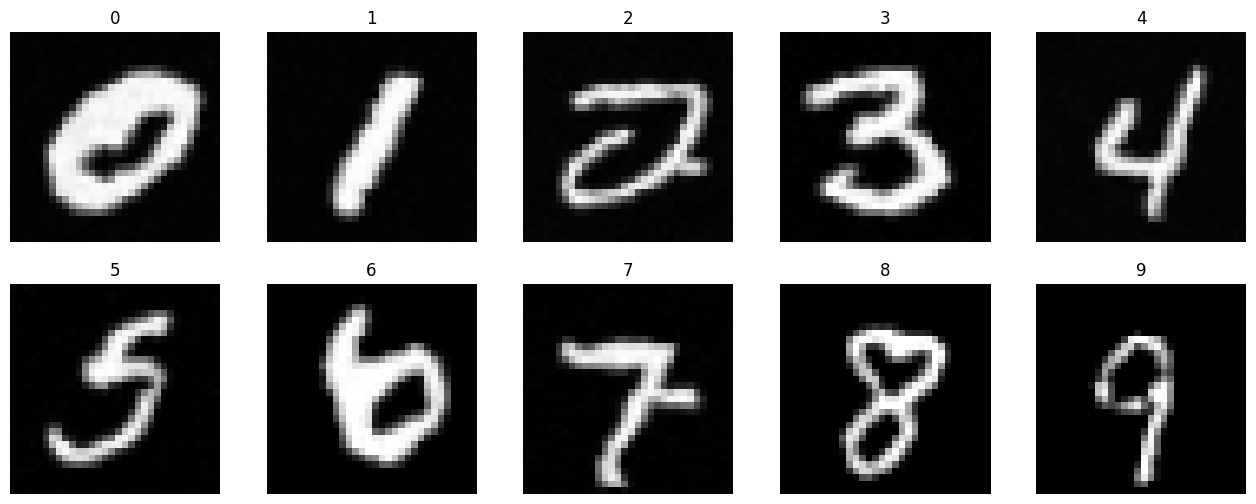

In [26]:
_, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(samples[i*5+j][0], cmap='gray')
        ax[i, j].axis('off')
        ax[i, j].set_title(i*5+j)

## Generation Process

In [36]:
samples, samples_process = diffusion.sample(model_ema, batch_size=10, y=torch.arange(10).to(device), process=True)

In [37]:
n_steps = 8

In [38]:
idx = np.arange(0, len(samples_process)+1, len(samples_process)//n_steps)

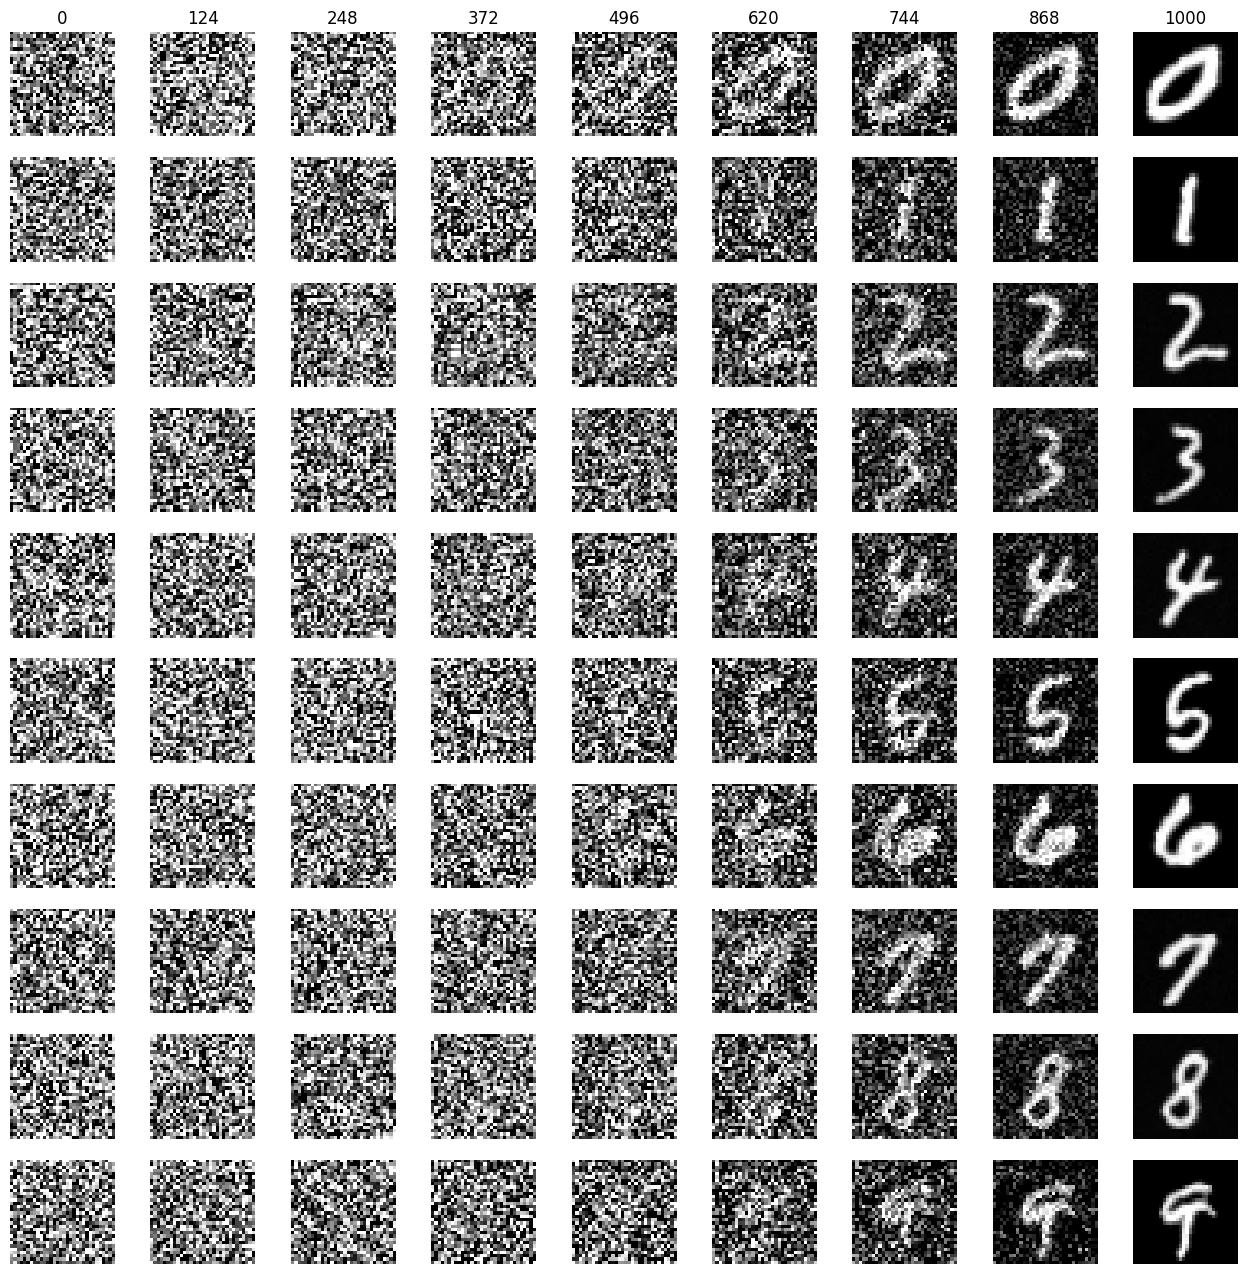

In [39]:
_, ax = plt.subplots(nrows=10, ncols=n_steps+1, figsize=(16, 16))
for i in range(10):
    for j in range(n_steps):
        ax[i, j].imshow(samples_process[idx[j]][i][0].cpu().numpy(), cmap='gray')
        ax[i, j].axis('off')
        if i == 0:
            ax[i, j].set_title(idx[j])
            ax[i, n_steps].set_title('1000')
    ax[i, n_steps].imshow(samples[i][0].cpu().numpy(), cmap='gray')
    ax[i, n_steps].axis('off')